In [21]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

In [22]:
%pip install swig
%pip install gymnasium[box2d]

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [24]:
NUM_EPISODES = 700
BATCH_SIZE = 64
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
TARGET_UPDATE = 20
LEARNING_RATE = 5e-4

In [27]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    def to(self, device):
        super().to(device)
        return self    


In [28]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    

In [35]:
class DQNAgent:
    def __init__(self, action_space, observation_space, lr=LEARNING_RATE):
        self.action_space = action_space
        self.policy = DQN(observation_space, action_space).to(device)
        self.target = DQN(observation_space, action_space).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr)
        self.memory = ReplayBuffer(10000)
        self.steps_done = 0

    def select_action(self, state, epsilon):
        if np.random.rand() < epsilon:
            return torch.tensor([[np.random.randint(self.action_space)]], dtype=torch.long, device=device)
        else:
            state = torch.as_tensor(state, dtype=torch.float32, device=device)
            if state.dim() == 1:
                state = state.unsqueeze(0)
            with torch.no_grad():
                q_values = self.policy(state)
                return q_values.max(1)[1].view(1, 1)
    
    def optimize_model(self, batch_size, gamma):
        if len(self.memory) < batch_size:
            return
        transitions = self.memory.sample(batch_size)
        batch = list(zip(*transitions))

        state_batch = torch.cat(batch[0]).to(device)
        action_batch = torch.cat(batch[1]).to(device)
        reward_batch = torch.cat(batch[2]).squeeze().to(device)
        next_state_batch = torch.cat(batch[3]).to(device)

        current_q_values = self.policy(state_batch).gather(1, action_batch)
        next_q_values = self.target(next_state_batch).max(1)[0].detach()
        expected_q_values = reward_batch + (gamma * next_q_values)
        loss = F.mse_loss(current_q_values.squeeze(), expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def update_target(self):
        self.target.load_state_dict(self.policy.state_dict())
            
        

In [33]:
def train(num_episodes=NUM_EPISODES,
        batch_size=BATCH_SIZE,
        gamma=GAMMA, 
        epsilon_start=EPSILON_START, 
        epsilon_end=EPSILON_END, 
        epsilon_decay=EPSILON_DECAY, 
        target_update=TARGET_UPDATE,
        learning_rate=LEARNING_RATE,
        ):
    
    env = gym.make('LunarLander-v3')
    #env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=100)
    env = gym.wrappers.TimeLimit(env, max_episode_steps=2000)
    agent = DQNAgent(env.action_space.n, env.observation_space.shape[0], learning_rate)

    episode_durations = []
    episode_rewards = []
    epsilon = epsilon_start

    for episode in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        total_reward = 0
        for t in range(2000):
            action = agent.select_action(state, epsilon)
            next_state, reward, done, trunc, _ = env.step(action.item())
            total_reward += reward
            reward = torch.tensor([reward], dtype=torch.float32, device=device)
            done = done or trunc

            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            agent.memory.push((state, action, reward, next_state))
            state = next_state
            agent.optimize_model(batch_size, gamma)
            if done:
                episode_durations.append(t + 1)
                episode_rewards.append(total_reward)
                break
            epsilon = max(epsilon_end, epsilon_start * (epsilon_decay ** episode))
        if episode % target_update == 0:
            agent.update_target()
        if episode % 25 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward:.2f}, AVG Reward(last 25 eps): {np.mean(episode_rewards[-25:]):.2f} Epsilon: {epsilon:.2f}")

    env.close()
    return agent, episode_rewards, episode_durations
        

In [31]:
def plot_rewards(rewards):    
    smooth_rewards = np.convolve(rewards, np.ones(25)/25, mode='valid')
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, alpha=0.3, label='Raw')
    plt.plot(range(24, len(rewards)), smooth_rewards, label='25-ep Moving Avg', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('DQN Training Performance')
    plt.legend()
    plt.show()

In [ ]:
agent, rewards, durations = train()
plot_rewards(rewards)
plt.figure(figsize=(10, 5))
plt.plot(durations)

Episode 0, Total Reward: -224.90, AVG Reward(last 25 eps): -224.90 Epsilon: 1.00
Episode 25, Total Reward: -278.15, AVG Reward(last 25 eps): -170.70 Epsilon: 0.88
Episode 50, Total Reward: -393.85, AVG Reward(last 25 eps): -151.35 Epsilon: 0.78
Episode 75, Total Reward: -86.15, AVG Reward(last 25 eps): -137.79 Epsilon: 0.69
Episode 100, Total Reward: -58.67, AVG Reward(last 25 eps): -108.37 Epsilon: 0.61


In [78]:
agent, rewards, durations = train()
plot_rewards(rewards)

Episode 0, Total Reward: -101.62522324696414, AVG Reward: -101.63 Epsilon: 1.00
Episode 25, Total Reward: -200.77087608047742, AVG Reward: -175.68 Epsilon: 0.88
Episode 50, Total Reward: -163.67564544107114, AVG Reward: -171.87 Epsilon: 0.78
Episode 75, Total Reward: -114.3206093041804, AVG Reward: -146.92 Epsilon: 0.69
Episode 100, Total Reward: -131.5959810360884, AVG Reward: -119.93 Epsilon: 0.61
Episode 125, Total Reward: -94.54074507023199, AVG Reward: -93.79 Epsilon: 0.53
Episode 150, Total Reward: -361.07129422664514, AVG Reward: -108.07 Epsilon: 0.47
Episode 175, Total Reward: -112.57993683886369, AVG Reward: -115.48 Epsilon: 0.42
Episode 200, Total Reward: -383.4584884032459, AVG Reward: -115.62 Epsilon: 0.37
Episode 225, Total Reward: 21.519353369552036, AVG Reward: -134.69 Epsilon: 0.32
Episode 250, Total Reward: 26.02742837735856, AVG Reward: -162.11 Epsilon: 0.29
Episode 275, Total Reward: -26.331965952107694, AVG Reward: -144.93 Epsilon: 0.25
Episode 300, Total Reward: -6

NameError: name 'plot_rewards' is not defined

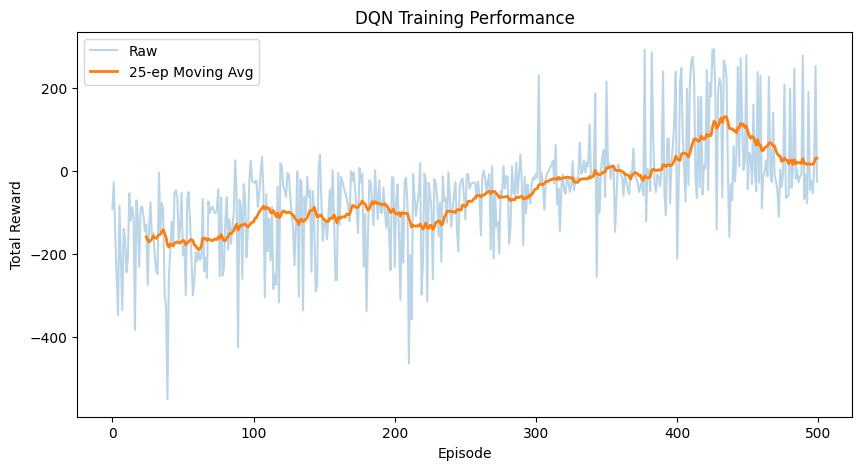

In [88]:
plot_rewards(rewards3)

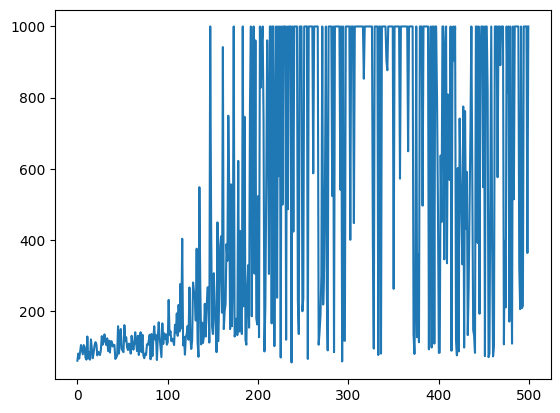

In [87]:
plt.plot(durations3)

In [ ]:
# agent3, rewards3, durations3 = train(500,64,0.99,1.0,0.01,0.995,10)
# plot_rewards(rewards3)

Episode 0, Total Reward: -309.22, AVG Reward(last 25 eps): -309.22 Epsilon: 1.00


KeyboardInterrupt: 

Episode 0, Total Reward: -216.10, AVG Reward(last 25 eps): -216.10 Epsilon: 1.00
Episode 25, Total Reward: -143.36, AVG Reward(last 25 eps): -180.12 Epsilon: 0.88
Episode 50, Total Reward: -49.95, AVG Reward(last 25 eps): -124.77 Epsilon: 0.78
Episode 75, Total Reward: -32.66, AVG Reward(last 25 eps): -139.70 Epsilon: 0.69
Episode 100, Total Reward: -110.43, AVG Reward(last 25 eps): -116.99 Epsilon: 0.61
Episode 125, Total Reward: -41.54, AVG Reward(last 25 eps): -113.80 Epsilon: 0.53
Episode 150, Total Reward: 31.75, AVG Reward(last 25 eps): -87.76 Epsilon: 0.47
Episode 175, Total Reward: -32.65, AVG Reward(last 25 eps): -69.99 Epsilon: 0.42
Episode 200, Total Reward: -47.88, AVG Reward(last 25 eps): -98.25 Epsilon: 0.37
Episode 225, Total Reward: -23.24, AVG Reward(last 25 eps): -108.83 Epsilon: 0.32
Episode 250, Total Reward: -4.60, AVG Reward(last 25 eps): -72.23 Epsilon: 0.29
Episode 275, Total Reward: -30.32, AVG Reward(last 25 eps): -62.86 Epsilon: 0.25
Episode 300, Total Reward

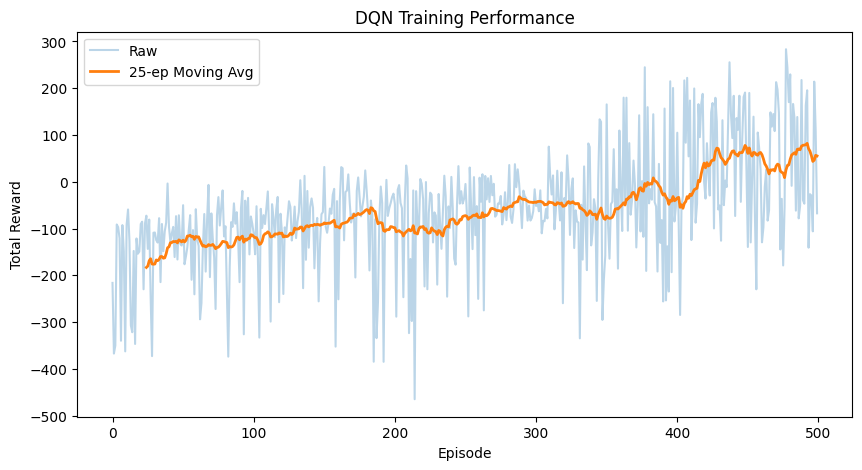

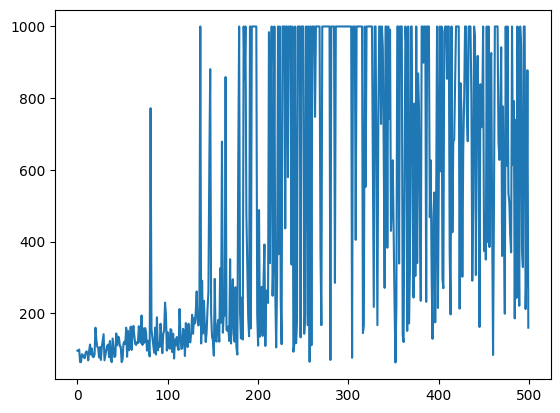

In [ ]:
agent4, rewards4, durations4 = train(500,64,0.99,1.0,0.01,0.995,15)
plot_rewards(rewards4)
plt.plot(durations4)


Episode 0, Total Reward: -148.79, AVG Reward(last 25 eps): -148.79 Epsilon: 1.00
Episode 25, Total Reward: -130.00, AVG Reward(last 25 eps): -187.29 Epsilon: 0.88
Episode 50, Total Reward: -141.76, AVG Reward(last 25 eps): -145.77 Epsilon: 0.78
Episode 75, Total Reward: -267.95, AVG Reward(last 25 eps): -133.65 Epsilon: 0.69
Episode 100, Total Reward: -360.12, AVG Reward(last 25 eps): -110.49 Epsilon: 0.61
Episode 125, Total Reward: -90.16, AVG Reward(last 25 eps): -82.92 Epsilon: 0.53
Episode 150, Total Reward: -46.47, AVG Reward(last 25 eps): -102.13 Epsilon: 0.47
Episode 175, Total Reward: -204.20, AVG Reward(last 25 eps): -98.76 Epsilon: 0.42
Episode 200, Total Reward: -40.31, AVG Reward(last 25 eps): -120.09 Epsilon: 0.37
Episode 225, Total Reward: -69.96, AVG Reward(last 25 eps): -151.82 Epsilon: 0.32
Episode 250, Total Reward: -23.52, AVG Reward(last 25 eps): -72.50 Epsilon: 0.29
Episode 275, Total Reward: -139.08, AVG Reward(last 25 eps): -92.79 Epsilon: 0.25
Episode 300, Total

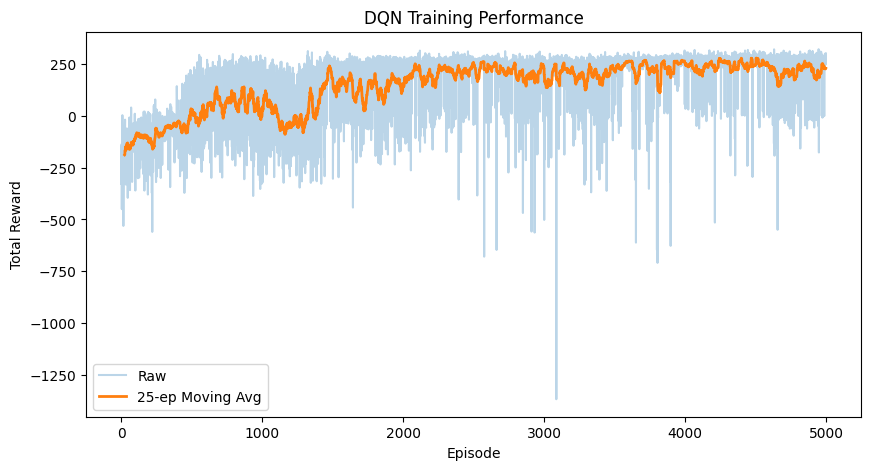

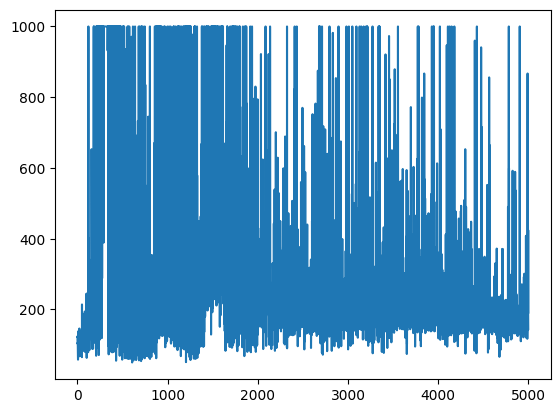

In [ ]:
# agent5, rewards5, durations5 = train(5000,64,0.99,1.0,0.01,0.995,20)
# plot_rewards(rewards5)
# plt.plot(durations5)

Episode 0, Total Reward: -130.84, AVG Reward(last 25 eps): -130.84 Epsilon: 1.00
Episode 25, Total Reward: -177.70, AVG Reward(last 25 eps): -163.88 Epsilon: 0.88
Episode 50, Total Reward: -175.23, AVG Reward(last 25 eps): -167.12 Epsilon: 0.78
Episode 75, Total Reward: -237.97, AVG Reward(last 25 eps): -124.79 Epsilon: 0.69
Episode 100, Total Reward: -68.81, AVG Reward(last 25 eps): -159.99 Epsilon: 0.61
Episode 125, Total Reward: -207.68, AVG Reward(last 25 eps): -184.77 Epsilon: 0.53
Episode 150, Total Reward: -155.37, AVG Reward(last 25 eps): -105.11 Epsilon: 0.47
Episode 175, Total Reward: -43.37, AVG Reward(last 25 eps): -81.90 Epsilon: 0.42
Episode 200, Total Reward: -126.08, AVG Reward(last 25 eps): -124.87 Epsilon: 0.37
Episode 225, Total Reward: -23.74, AVG Reward(last 25 eps): -99.91 Epsilon: 0.32
Episode 250, Total Reward: -208.63, AVG Reward(last 25 eps): -141.54 Epsilon: 0.29
Episode 275, Total Reward: -421.02, AVG Reward(last 25 eps): -157.45 Epsilon: 0.25
Episode 300, T

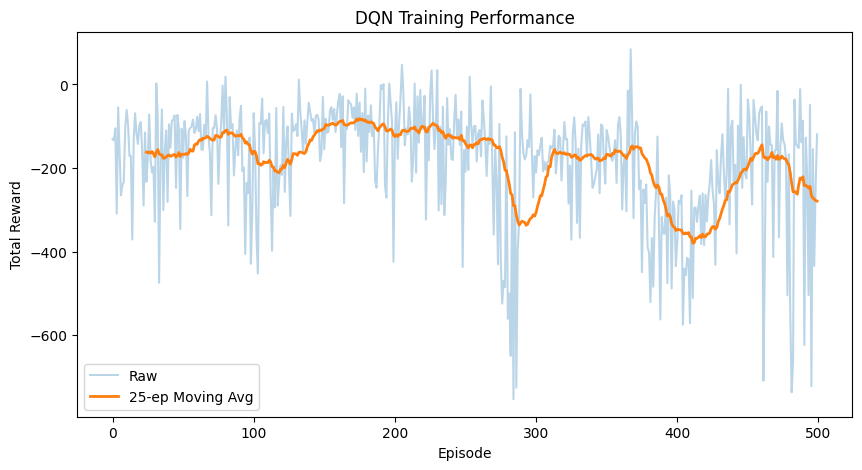

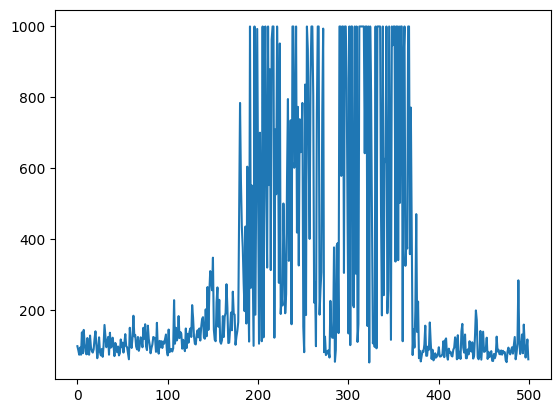

In [9]:
agent7, rewards7, durations7 = train(500,64,0.99,1.0,0.01,0.995,15, 5e-3)
plot_rewards(rewards7)
plt.plot(durations7)

### 5e-3 is too unstable

Episode 0, Total Reward: -169.08, AVG Reward(last 25 eps): -169.08 Epsilon: 1.00
Episode 25, Total Reward: -149.85, AVG Reward(last 25 eps): -184.96 Epsilon: 0.88
Episode 50, Total Reward: -18.34, AVG Reward(last 25 eps): -165.43 Epsilon: 0.78
Episode 75, Total Reward: -46.98, AVG Reward(last 25 eps): -136.48 Epsilon: 0.69
Episode 100, Total Reward: -154.63, AVG Reward(last 25 eps): -154.04 Epsilon: 0.61
Episode 125, Total Reward: -272.29, AVG Reward(last 25 eps): -186.84 Epsilon: 0.53
Episode 150, Total Reward: -220.04, AVG Reward(last 25 eps): -132.58 Epsilon: 0.47
Episode 175, Total Reward: -95.27, AVG Reward(last 25 eps): -129.16 Epsilon: 0.42
Episode 200, Total Reward: -46.26, AVG Reward(last 25 eps): -146.68 Epsilon: 0.37
Episode 225, Total Reward: -238.80, AVG Reward(last 25 eps): -156.64 Epsilon: 0.32
Episode 250, Total Reward: -134.52, AVG Reward(last 25 eps): -198.63 Epsilon: 0.29
Episode 275, Total Reward: -93.20, AVG Reward(last 25 eps): -185.67 Epsilon: 0.25
Episode 300, T

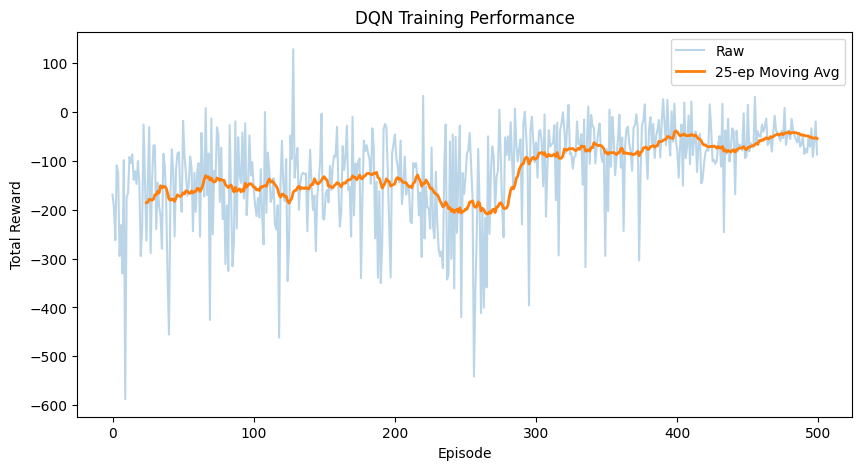

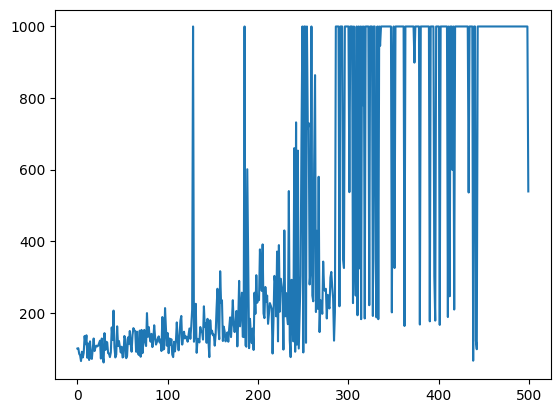

In [10]:
agent8, rewards8, durations8 = train(500,64,0.99,1.0,0.01,0.995,15, 5e-5)
plot_rewards(rewards8)
plt.plot(durations8)

Episode 0, Total Reward: -125.14, AVG Reward(last 25 eps): -125.14 Epsilon: 1.00
Episode 25, Total Reward: -93.54, AVG Reward(last 25 eps): -173.73 Epsilon: 0.88
Episode 50, Total Reward: -62.97, AVG Reward(last 25 eps): -146.96 Epsilon: 0.78
Episode 75, Total Reward: -170.70, AVG Reward(last 25 eps): -102.70 Epsilon: 0.69
Episode 100, Total Reward: -184.44, AVG Reward(last 25 eps): -115.48 Epsilon: 0.61
Episode 125, Total Reward: -351.65, AVG Reward(last 25 eps): -123.67 Epsilon: 0.53
Episode 150, Total Reward: -104.39, AVG Reward(last 25 eps): -134.36 Epsilon: 0.47
Episode 175, Total Reward: -124.39, AVG Reward(last 25 eps): -132.62 Epsilon: 0.42
Episode 200, Total Reward: -134.63, AVG Reward(last 25 eps): -140.60 Epsilon: 0.37
Episode 225, Total Reward: -60.71, AVG Reward(last 25 eps): -84.63 Epsilon: 0.32
Episode 250, Total Reward: -80.40, AVG Reward(last 25 eps): -81.42 Epsilon: 0.29
Episode 275, Total Reward: -94.57, AVG Reward(last 25 eps): -50.82 Epsilon: 0.25
Episode 300, Tota

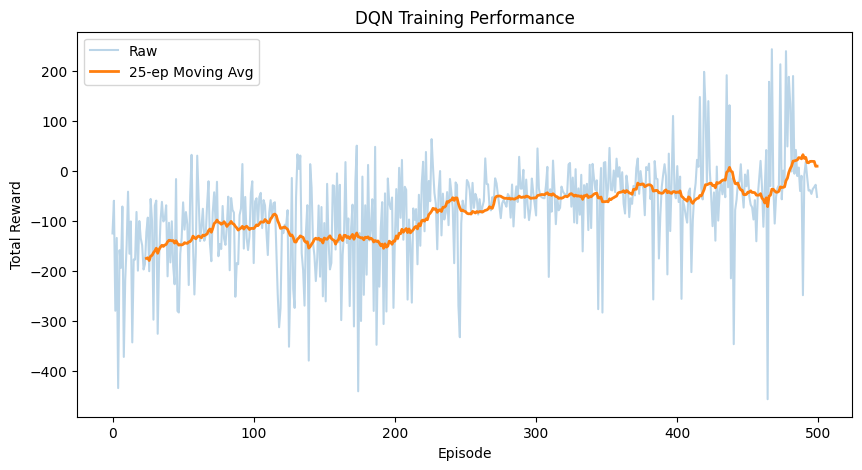

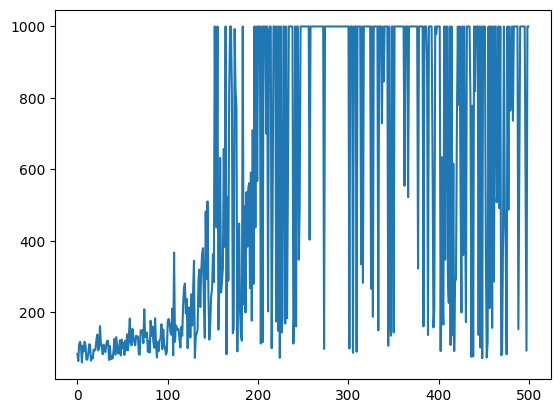

In [11]:
agent9, rewards9, durations9 = train(500,64,0.99,1.0,0.01,0.995,15, 5e-4)
plot_rewards(rewards9)
plt.plot(durations9)

### Seems like 5e-4 is the best learning rate. Testing with 1000 episodes now:

Episode 0, Total Reward: -303.97, AVG Reward(last 25 eps): -303.97 Epsilon: 1.00
Episode 25, Total Reward: -186.03, AVG Reward(last 25 eps): -184.83 Epsilon: 0.88
Episode 50, Total Reward: -276.28, AVG Reward(last 25 eps): -161.17 Epsilon: 0.78
Episode 75, Total Reward: -68.90, AVG Reward(last 25 eps): -138.82 Epsilon: 0.69
Episode 100, Total Reward: -82.62, AVG Reward(last 25 eps): -120.80 Epsilon: 0.61
Episode 125, Total Reward: -52.41, AVG Reward(last 25 eps): -104.95 Epsilon: 0.53
Episode 150, Total Reward: -240.45, AVG Reward(last 25 eps): -88.51 Epsilon: 0.47
Episode 175, Total Reward: -125.21, AVG Reward(last 25 eps): -62.68 Epsilon: 0.42
Episode 200, Total Reward: -121.08, AVG Reward(last 25 eps): -64.49 Epsilon: 0.37
Episode 225, Total Reward: -1.96, AVG Reward(last 25 eps): -88.60 Epsilon: 0.32
Episode 250, Total Reward: -299.94, AVG Reward(last 25 eps): -49.22 Epsilon: 0.29
Episode 275, Total Reward: -102.32, AVG Reward(last 25 eps): -75.99 Epsilon: 0.25
Episode 300, Total R

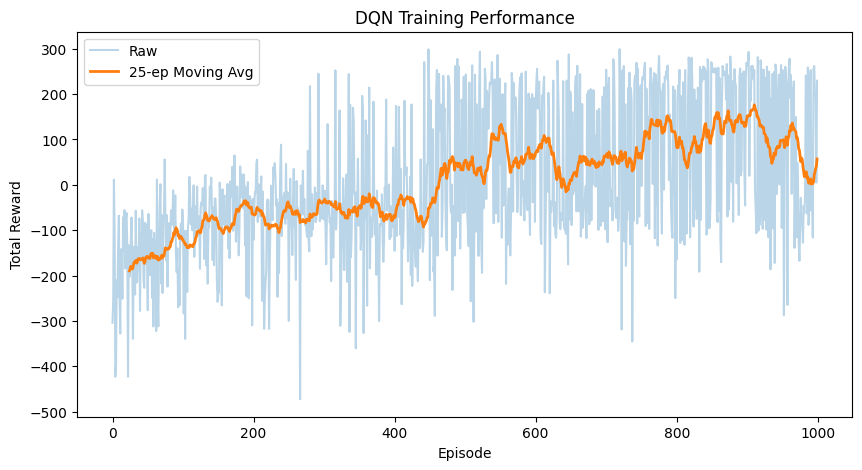

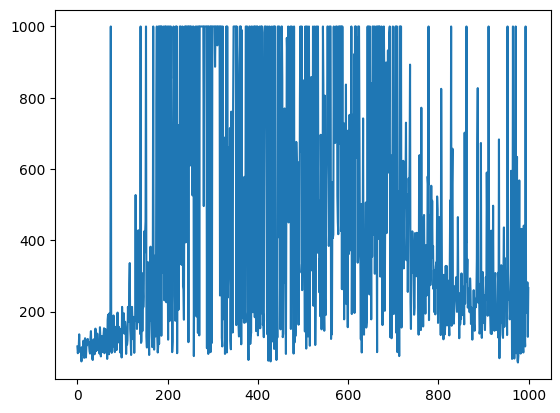

In [12]:
agent10, rewards10, durations10 = train(1000,64,0.99,1.0,0.01,0.995,15, 5e-4)
plot_rewards(rewards10)
plt.plot(durations10)

### Seems like around 700 episodes are needed to reach above 250 average reward with current configs

### Testing after setting limit of actions per episode to 2000:

Episode 0, Total Reward: -39.97, AVG Reward(last 25 eps): -39.97 Epsilon: 1.00
Episode 25, Total Reward: -105.30, AVG Reward(last 25 eps): -206.51 Epsilon: 0.88
Episode 50, Total Reward: -219.62, AVG Reward(last 25 eps): -145.44 Epsilon: 0.78
Episode 75, Total Reward: -19.11, AVG Reward(last 25 eps): -145.83 Epsilon: 0.69
Episode 100, Total Reward: -29.31, AVG Reward(last 25 eps): -112.34 Epsilon: 0.61
Episode 125, Total Reward: 18.03, AVG Reward(last 25 eps): -110.86 Epsilon: 0.53
Episode 150, Total Reward: -62.19, AVG Reward(last 25 eps): -80.75 Epsilon: 0.47
Episode 175, Total Reward: -36.10, AVG Reward(last 25 eps): -106.43 Epsilon: 0.42
Episode 200, Total Reward: -204.43, AVG Reward(last 25 eps): -136.67 Epsilon: 0.37
Episode 225, Total Reward: -99.57, AVG Reward(last 25 eps): -150.82 Epsilon: 0.32
Episode 250, Total Reward: -33.70, AVG Reward(last 25 eps): -74.67 Epsilon: 0.29
Episode 275, Total Reward: -7.87, AVG Reward(last 25 eps): -60.56 Epsilon: 0.25
Episode 300, Total Rewar

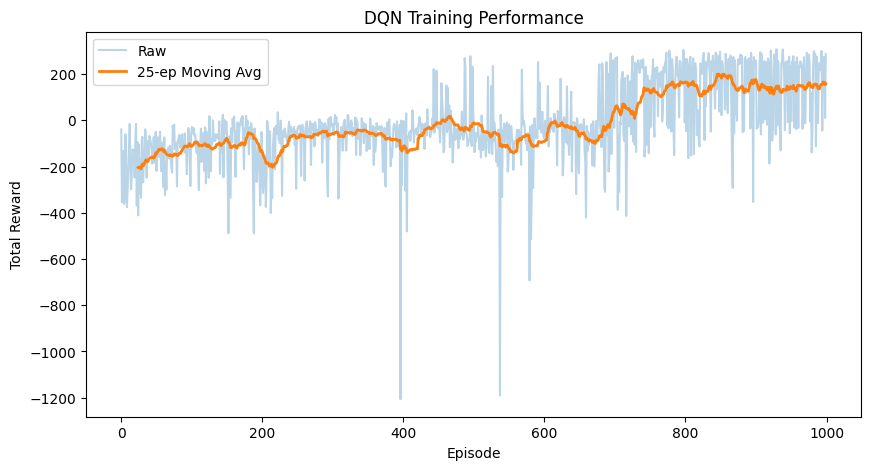

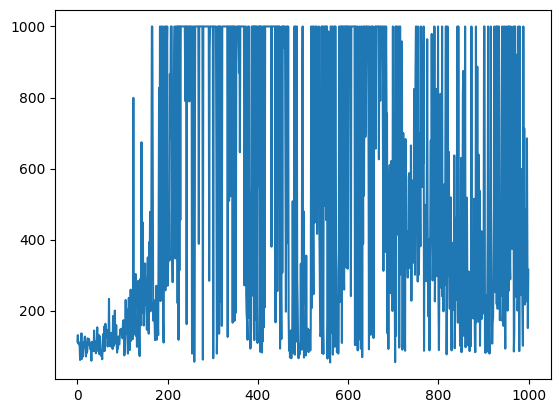

In [14]:
agent, rewards, durations = train(1000,64,0.99,1.0,0.01,0.995,15, 5e-4)
plot_rewards(rewards)
plt.plot(durations)

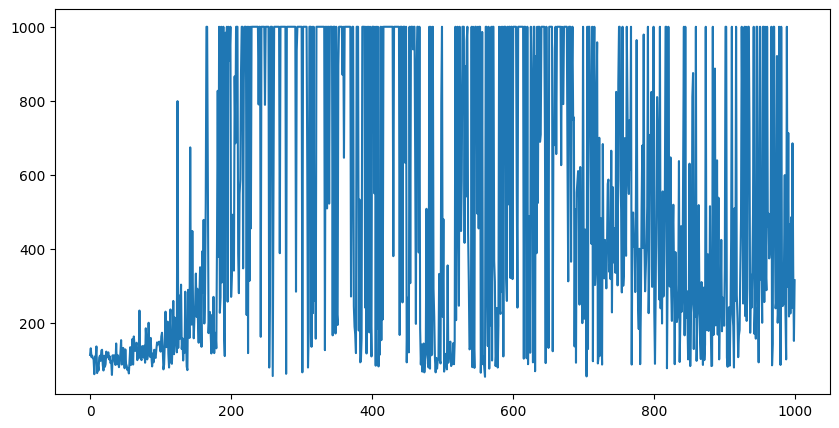

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(durations)

### testing faster epsilon decay with 700 eps

Episode 0, Total Reward: -193.42, AVG Reward(last 25 eps): -193.42 Epsilon: 1.00
Episode 25, Total Reward: -186.90, AVG Reward(last 25 eps): -201.25 Epsilon: 0.28
Episode 50, Total Reward: 202.23, AVG Reward(last 25 eps): -168.45 Epsilon: 0.08
Episode 75, Total Reward: -510.66, AVG Reward(last 25 eps): -180.54 Epsilon: 0.02
Episode 100, Total Reward: -20.54, AVG Reward(last 25 eps): -101.03 Epsilon: 0.01
Episode 125, Total Reward: -162.21, AVG Reward(last 25 eps): -116.85 Epsilon: 0.01
Episode 150, Total Reward: -262.39, AVG Reward(last 25 eps): -103.24 Epsilon: 0.01
Episode 175, Total Reward: -42.28, AVG Reward(last 25 eps): -74.11 Epsilon: 0.01
Episode 200, Total Reward: -159.31, AVG Reward(last 25 eps): -40.20 Epsilon: 0.01
Episode 225, Total Reward: -231.44, AVG Reward(last 25 eps): -83.56 Epsilon: 0.01
Episode 250, Total Reward: -138.85, AVG Reward(last 25 eps): -99.79 Epsilon: 0.01
Episode 275, Total Reward: -98.13, AVG Reward(last 25 eps): -98.11 Epsilon: 0.01
Episode 300, Total

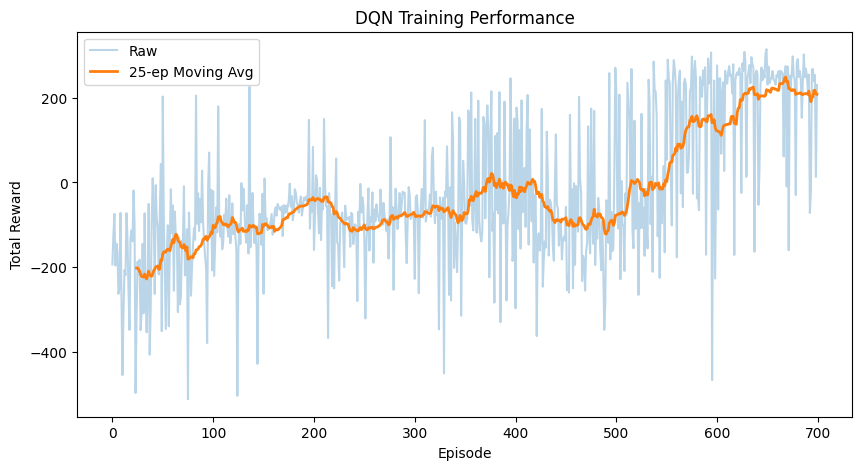

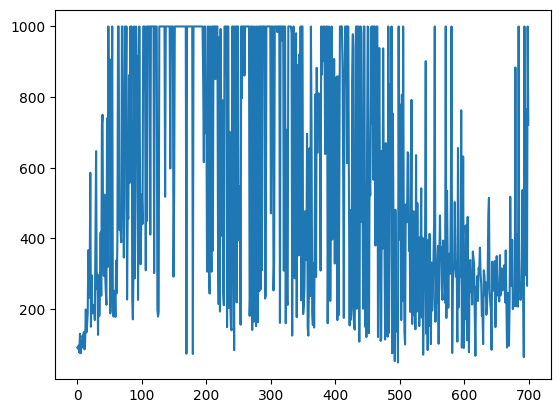

In [16]:
agent, rewards, durations = train(700,64,0.99,1.0,0.01,0.95,15, 5e-4)
plot_rewards(rewards)
plt.figure(figsize=(10, 5))
plt.plot(durations)

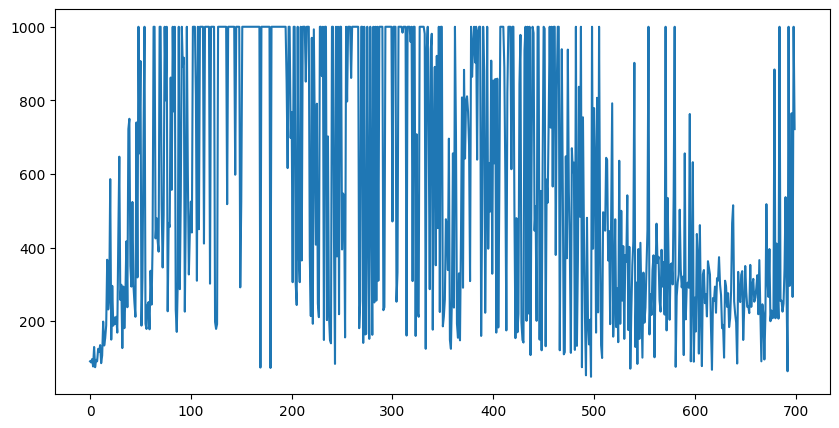

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(durations)

### Slightly faster decay:

Episode 0, Total Reward: -124.44, AVG Reward(last 25 eps): -124.44 Epsilon: 1.00
Episode 25, Total Reward: -130.91, AVG Reward(last 25 eps): -171.16 Epsilon: 0.82
Episode 50, Total Reward: -34.22, AVG Reward(last 25 eps): -122.53 Epsilon: 0.67
Episode 75, Total Reward: -139.92, AVG Reward(last 25 eps): -143.66 Epsilon: 0.55
Episode 100, Total Reward: -164.80, AVG Reward(last 25 eps): -113.67 Epsilon: 0.45
Episode 125, Total Reward: -83.12, AVG Reward(last 25 eps): -104.72 Epsilon: 0.37
Episode 150, Total Reward: -176.45, AVG Reward(last 25 eps): -128.77 Epsilon: 0.30
Episode 175, Total Reward: -85.36, AVG Reward(last 25 eps): -128.70 Epsilon: 0.25
Episode 200, Total Reward: -16.72, AVG Reward(last 25 eps): -104.50 Epsilon: 0.20
Episode 225, Total Reward: -59.19, AVG Reward(last 25 eps): -72.09 Epsilon: 0.16
Episode 250, Total Reward: -305.18, AVG Reward(last 25 eps): -113.43 Epsilon: 0.13
Episode 275, Total Reward: -59.23, AVG Reward(last 25 eps): -74.56 Epsilon: 0.11
Episode 300, Tota

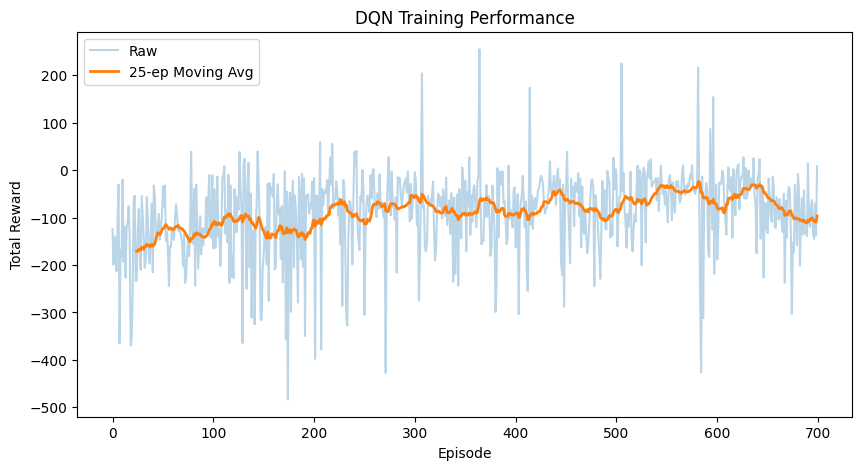

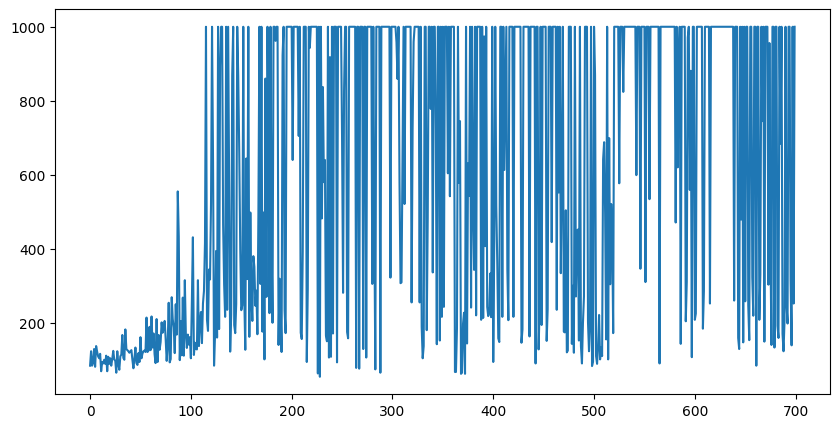

In [18]:
agent, rewards, durations = train(700,64,0.99,1.0,0.01,0.992,15, 5e-4)
plot_rewards(rewards)
plt.figure(figsize=(10, 5))
plt.plot(durations)

### faster target updates:

Episode 0, Total Reward: -229.06, AVG Reward(last 25 eps): -229.06 Epsilon: 1.00
Episode 25, Total Reward: -76.74, AVG Reward(last 25 eps): -153.99 Epsilon: 0.82
Episode 50, Total Reward: -32.99, AVG Reward(last 25 eps): -114.97 Epsilon: 0.67
Episode 75, Total Reward: -39.48, AVG Reward(last 25 eps): -113.22 Epsilon: 0.55
Episode 100, Total Reward: -89.63, AVG Reward(last 25 eps): -96.41 Epsilon: 0.45
Episode 125, Total Reward: -156.34, AVG Reward(last 25 eps): -87.22 Epsilon: 0.37
Episode 150, Total Reward: -2.08, AVG Reward(last 25 eps): -50.12 Epsilon: 0.30
Episode 175, Total Reward: -67.13, AVG Reward(last 25 eps): -53.62 Epsilon: 0.25
Episode 200, Total Reward: -50.12, AVG Reward(last 25 eps): -37.04 Epsilon: 0.20
Episode 225, Total Reward: -33.34, AVG Reward(last 25 eps): -35.05 Epsilon: 0.16
Episode 250, Total Reward: -31.43, AVG Reward(last 25 eps): -51.43 Epsilon: 0.13
Episode 275, Total Reward: -32.46, AVG Reward(last 25 eps): -102.78 Epsilon: 0.11
Episode 300, Total Reward: 

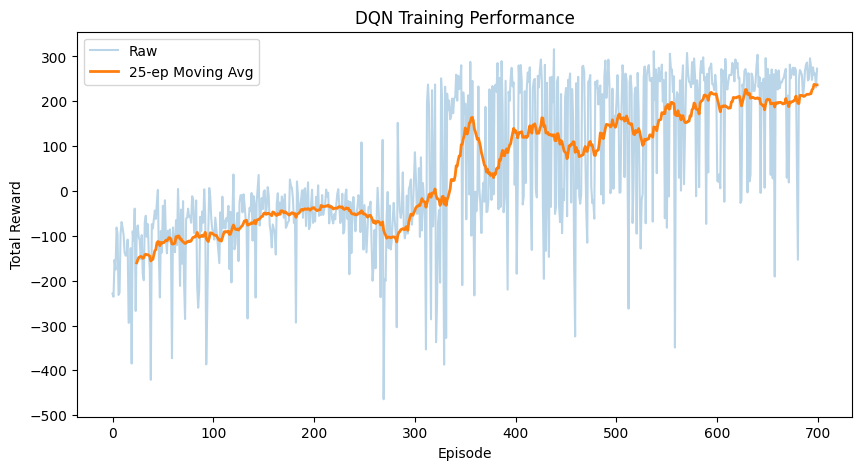

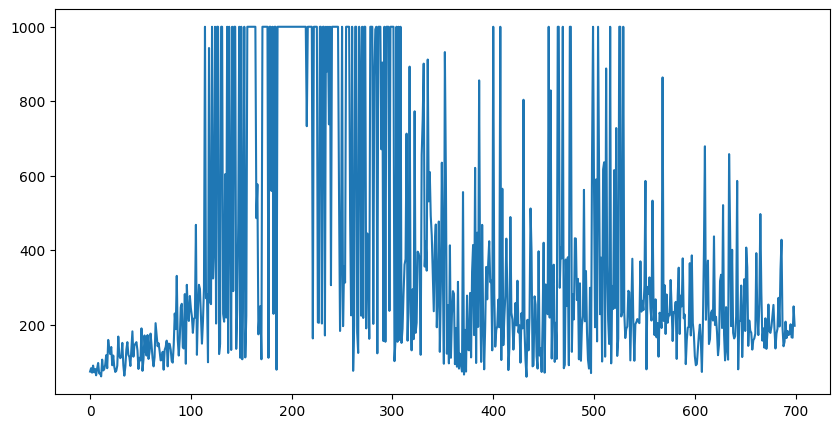

In [19]:
agent, rewards, durations = train(700,64,0.99,1.0,0.01,0.992,10, 5e-4)
plot_rewards(rewards)
plt.figure(figsize=(10, 5))
plt.plot(durations)

### slower target updates:

Episode 0, Total Reward: -84.39, AVG Reward(last 25 eps): -84.39 Epsilon: 1.00
Episode 25, Total Reward: -188.32, AVG Reward(last 25 eps): -152.90 Epsilon: 0.82
Episode 50, Total Reward: -69.96, AVG Reward(last 25 eps): -118.76 Epsilon: 0.67
Episode 75, Total Reward: -124.96, AVG Reward(last 25 eps): -164.13 Epsilon: 0.55
Episode 100, Total Reward: -11.77, AVG Reward(last 25 eps): -136.17 Epsilon: 0.45
Episode 125, Total Reward: -78.34, AVG Reward(last 25 eps): -136.95 Epsilon: 0.37
Episode 150, Total Reward: -269.50, AVG Reward(last 25 eps): -115.35 Epsilon: 0.30
Episode 175, Total Reward: -284.93, AVG Reward(last 25 eps): -168.28 Epsilon: 0.25
Episode 200, Total Reward: -119.76, AVG Reward(last 25 eps): -128.54 Epsilon: 0.20
Episode 225, Total Reward: -87.86, AVG Reward(last 25 eps): -109.86 Epsilon: 0.16
Episode 250, Total Reward: -141.07, AVG Reward(last 25 eps): -99.95 Epsilon: 0.13
Episode 275, Total Reward: -65.88, AVG Reward(last 25 eps): -74.31 Epsilon: 0.11
Episode 300, Total

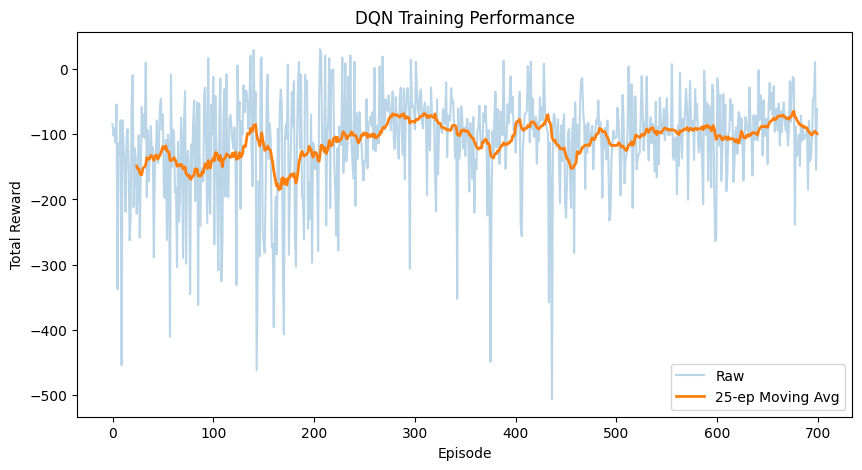

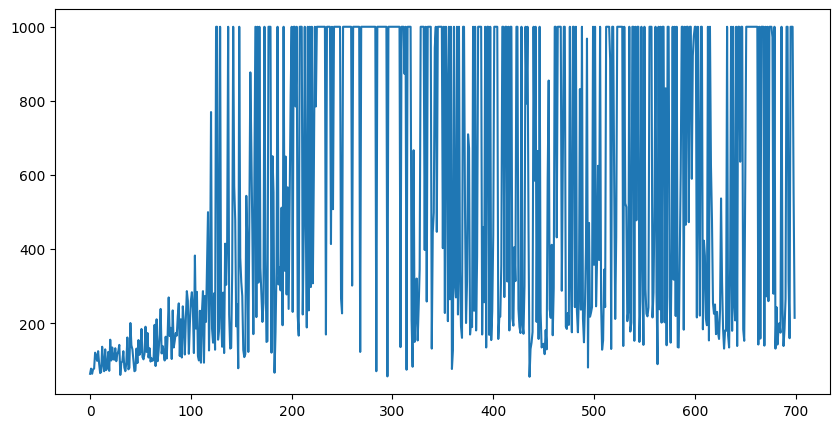

In [20]:
agent, rewards, durations = train(700,64,0.99,1.0,0.01,0.992,20, 5e-4)
plot_rewards(rewards)
plt.figure(figsize=(10, 5))
plt.plot(durations)